# DESeq2 analysis between GDC bam counts vs GDC fastq counts (both "reprocessed" in other notebooks)

Performs DESeq2 analysis between counts generated from GDC samples via their fastq files and counts generated from GDC samples via their bam files (converted to fastq by Biobambam). Any genes labelled as DEGs by DESeq2 are noted.

In [ ]:
if (!require("dplyr", quietly = TRUE))
    install.packages("dplyr")
install.packages("tidyverse")
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install('locfit')
BiocManager::install("EnhancedVolcano", dependencies = T)
BiocManager::install("DESeq2", dependencies = T)
BiocManager::install("biomaRt")
BiocManager::install("gplots")

# In the case EnhancedVolcano fails to install using BiocManager, pull the package off of github
if (!require("EnhancedVolcano", quietly = TRUE))
    devtools::install_github('kevinblighe/EnhancedVolcano')

install.packages('devtools')

install.packages("readxl")
install.packages("tibble")

In [1]:
# Import libraries
library("dplyr")
library("readxl")
library("DESeq2")
library("EnhancedVolcano")
library("gplots")
library("tibble")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package

In [2]:
# Load counts files
filenames <- list.files(pattern = "REPROCESSED", full.names = T, include.dirs = F)
filenames

# Store all counts data in list of dataframes
counts <- list()
for (i in seq_along(filenames)) {
    counts[[i]] <- read.table(file = filenames[i], header = T, sep = "\t")
    # Remove decimals and numbers after decimals
    counts[[i]]$genes <- sub("\\..*", "", counts[[i]]$genes)
    # Remove any duplicate listed genes
    counts[[i]] <- counts[[i]] %>% distinct(genes, .keep_all = T)
}

names(counts) <- list.files(pattern = "REPROCESSED")

# Seperate counts from fastq and counts from bam
fastq.counts <-counts[grep("_fastq", names(counts))]
bam.counts <-counts[grep("_bam", names(counts))]

[1] "./gdc2821counts_REPROCESSED_bam.counts"  
[2] "./gdc2821counts_REPROCESSED_fastq.counts"
[3] "./gdc2828counts_REPROCESSED_bam.counts"  
[4] "./gdc2828counts_REPROCESSED_fastq.counts"
[5] "./gdc2839counts_REPROCESSED_bam.counts"  
[6] "./gdc2839counts_REPROCESSED_fastq.counts"

### Functions for analysis

In [3]:
# A function to select subset of dataframes to analyze in DESeq2.
# Returns one dataframe containing GTEx and GDC samples aand their counts, genes listed as row names.
createDataframe <- function(dfList1, dfList2) {
    # Combine GTEx and GDC dataframes to one list
    counts.combined <- c(dfList1, dfList2)

    # Merge all dataframes in list into one dataframe based on "genes" column (non-overlapping genes removed)
    counts.combined.df <- Reduce(function(...) merge(..., by = 'genes'), counts.combined)

    # Remove any duplicate listed genes
    counts.combined.df <- counts.combined.df %>% distinct(genes, .keep_all = T)

    # Make genes column as row names, remove from dataframe
    dimnames(counts.combined.df)[[1]] <- counts.combined.df[,1]
    counts.combined.df <- counts.combined.df[, -1]
    
    return(counts.combined.df)
}

# A function to create annotation dataframe from dataframe input, returns the annotation dataframe.
# Returns one dataframe containing the sample and their condition for DESeq2, "meta" dataframe
createAnnotations <- function(df) {
    colName <- colnames(df)
    condition <- vector()
    for (col in colName) {
        if (grepl("_bam", col, fixed = T)) {
            # column is bam, label as "disease"
            condition <- append(condition, "bam")
        } else {
            # column is fastq, label as "normal"
            condition <- append(condition, "fastq")
        }
    }
    
    return(data.frame(colName, condition))
}
                                 
# A function to get DESEQDataSet (dds) and perform DESeq on it, returns the dds after DESeq
# Inputs are the counts dataframe and meta dataframe
# Returns DESEQDataSet output and perform DESeq on it
performDeseq <- function(countDf, metaDf) {
    dds <- DESeqDataSetFromMatrix(countData = round(countDf), colData = metaDf, design= ~ condition)
    dds <- DESeq(dds)
    return(dds)
}

### Setup dataframes and metadata for DESeq2

In [4]:
# DESeq2 counts in one dataframe
bamvsfastq.counts <- createDataframe(fastq.counts, bam.counts)

dim(bamvsfastq.counts)
head(bamvsfastq.counts)

[1] 60616     6

,GDC2821countsREPROCESSED_fastq,GDC2828countsREPROCESSED_fastq,GDC2839countsREPROCESSED_fastq,GDC2821countsREPROCESSED_bam,GDC2828countsREPROCESSED_bam,GDC2839countsREPROCESSED_bam
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,45,4,3,48,6,5
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,412,801,473,454,914,687
ENSG00000000457,720,571,682,768,669,992
ENSG00000000460,621,536,387,669,618,591
ENSG00000000938,2622,9821,689,2852,11302,975


In [5]:
# DESeq2 meta data setup
bamvsfastq.counts.meta <- createAnnotations(bamvsfastq.counts)
bamvsfastq.counts.meta

colName,condition
<chr>,<chr>
GDC2821countsREPROCESSED_fastq,fastq
GDC2828countsREPROCESSED_fastq,fastq
GDC2839countsREPROCESSED_fastq,fastq
GDC2821countsREPROCESSED_bam,bam
GDC2828countsREPROCESSED_bam,bam
GDC2839countsREPROCESSED_bam,bam


### DESeq2, alpha = 0.01

In [6]:
# Get DESEQDataSet (dds) and perform DESeq on it
bamvsfastq.dds <- performDeseq(bamvsfastq.counts, bamvsfastq.counts.meta)

# Get the result from DESeq2 into dataframe
bamvsfastq.dds.res <- results(bamvsfastq.dds, alpha = 0.01)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [7]:
bamvsfastq.dds.res

log2 fold change (MLE): condition fastq vs bam 
Wald test p-value: condition fastq vs bam 
DataFrame with 60616 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003   16.9394      0.0100082  1.328562 0.00753309  0.993990
ENSG00000000005    0.0000             NA        NA         NA        NA
ENSG00000000419  618.1174      0.0862240  0.502267 0.17166956  0.863697
ENSG00000000457  726.5690      0.0943235  0.352189 0.26782094  0.788837
ENSG00000000460  556.2209      0.0594415  0.211240 0.28139324  0.778409
...                   ...            ...       ...        ...       ...
ENSG00000288669   0.29243     -1.4992426  4.036880 -0.3713865  0.710350
ENSG00000288670 189.66602      0.0927543  0.300284  0.3088890  0.757406
ENSG00000288671   0.00000             NA        NA         NA        NA
ENSG00000288674  16.98575     -0.2069072  0.978553 -0.2114419  0.832542
ENSG0

In [8]:
sum(bamvsfastq.dds.res$padj < 0.01, na.rm = T)

# out of...
dim(bamvsfastq.counts)

[1] 27

[1] 60616     6

**27 Genes are labelled DEGs between using bam and fastq inputs**

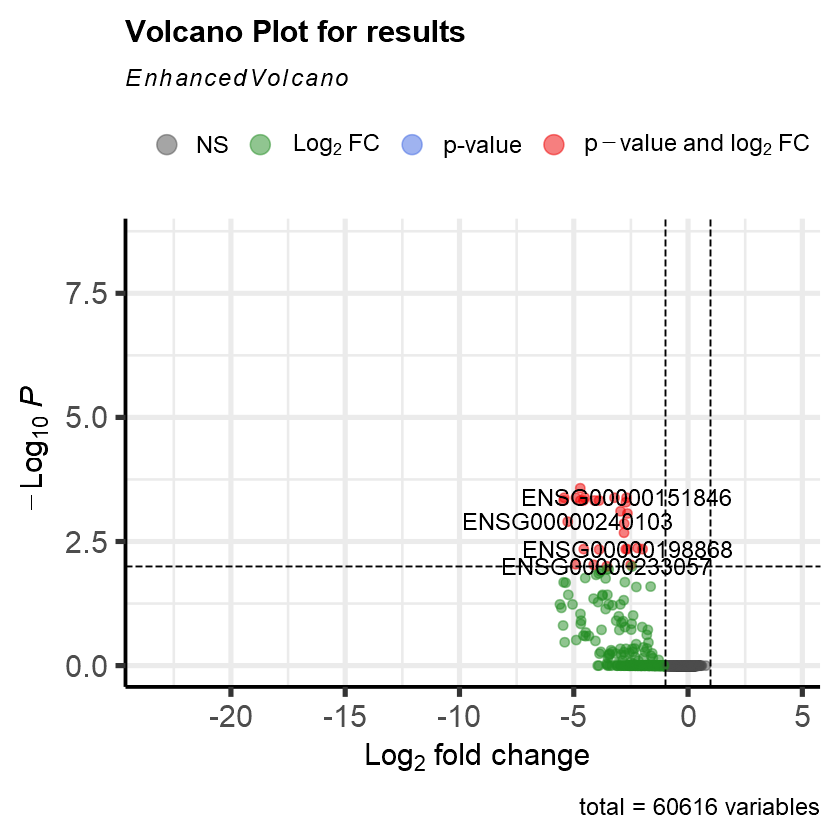

In [9]:
# Make a volcano plot for results
EnhancedVolcano(bamvsfastq.dds.res,
    lab = rownames(bamvsfastq.dds.res),
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.01)

In [10]:
# Convert DESeq2 results as dataframe, sorted padj value in ascending order
bamvsfastq.dds.res.df <- as.data.frame(bamvsfastq.dds.res[order(bamvsfastq.dds.res$padj),])

In [11]:
bamvsfastq.dds.res.df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000230916,69.84783,-4.715611,0.8255123,-5.712345,1.114300e-08,0.0002665072
ENSG00000151846,97.29920,-2.691179,0.5012641,-5.368785,7.926902e-08,0.0004147345
ENSG00000227939,32.80919,-3.217116,0.5922381,-5.432133,5.568442e-08,0.0004147345
ENSG00000237709,30.98043,-4.523755,0.8453998,-5.351024,8.745787e-08,0.0004147345
ENSG00000270350,23.91918,-5.418309,1.0185716,-5.319516,1.040434e-07,0.0004147345
ENSG00000271207,60.06496,-4.907471,0.9102494,-5.391347,6.993139e-08,0.0004147345
ENSG00000232177,48.17231,-4.708974,0.9033060,-5.213044,1.857668e-07,0.0004715345
ENSG00000249780,25.05350,-5.442970,1.0428761,-5.219192,1.797058e-07,0.0004715345
ENSG00000259612,41.92274,-3.893410,0.7510054,-5.184264,2.168700e-07,0.0004715345


In [18]:
# List the differing genes
rownames(bamvsfastq.dds.res.df[seq(1,27),])
bamvsfastq.degs <- rownames(bamvsfastq.dds.res.df[seq(1,27),])

[1] "ENSG00000230916" "ENSG00000151846" "ENSG00000227939" "ENSG00000237709"
 [5] "ENSG00000270350" "ENSG00000271207" "ENSG00000232177" "ENSG00000249780"
 [9] "ENSG00000259612" "ENSG00000268222" "ENSG00000270906" "ENSG00000228205"
[13] "ENSG00000255642" "ENSG00000183199" "ENSG00000240103" "ENSG00000240376"
[17] "ENSG00000225093" "ENSG00000249264" "ENSG00000198868" "ENSG00000223668"
[21] "ENSG00000247627" "ENSG00000248626" "ENSG00000223529" "ENSG00000270388"
[25] "ENSG00000224411" "ENSG00000250144" "ENSG00000233057"

In [13]:
# copy to clipboard
writeClipboard(rownames(bamvsfastq.dds.res.df[seq(1,27),]))

In [19]:
# Isolate counts dataframe to just the 27 degs
bamvsfastq.counts[rownames(bamvsfastq.counts) %in% bamvsfastq.degs,]

,GDC2821countsREPROCESSED_fastq,GDC2828countsREPROCESSED_fastq,GDC2839countsREPROCESSED_fastq,GDC2821countsREPROCESSED_bam,GDC2828countsREPROCESSED_bam,GDC2839countsREPROCESSED_bam
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000151846,22,34,15,127,233,219
ENSG00000183199,15,13,12,74,92,158
ENSG00000198868,11,8,6,44,63,93
ENSG00000223529,7,14,1,64,185,145
ENSG00000223668,10,15,8,53,100,126
ENSG00000224411,10,9,6,39,64,77
ENSG00000225093,9,12,4,50,83,85
ENSG00000227939,4,8,5,54,67,83
ENSG00000228205,15,9,12,75,90,141


In [21]:
# write these counts for DEGs as csv
write.csv(bamvsfastq.counts[rownames(bamvsfastq.counts) %in% bamvsfastq.degs,], "GDC bam counts vs fastq counts DEG counts.csv", row.names = T)